<br>
# Mortgage Payments
### CPI Indexed vs Non-Indexed<br>
by<br><br>
Haukur Hannesson &<br>Thorsteinn Nielsen<br>


Data Bootcamp ECON-GB.2313, Spring 2017<br>
NYU Stern School of Business<br><br>
![RVK](https://upload.wikimedia.org/wikipedia/commons/8/8a/Reykjavik_Esja.jpg)
["Esja Reykjavik"](https://upload.wikimedia.org/wikipedia/commons/8/8a/Reykjavik_Esja.jpg) by [MartinPutz](http://martinputz.com/) is licensed under [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en)

# Introduction

Before we dive further into the topic of this analysis it helps to understand the differences between the two main mortgage options in question. Namely CPI (Consumer Price Index) indexed mortgage loans and non-indexed mortgage loans. The following descriptions will help distinguish between the two options and establish the readers understanding of the analysis.

A CPI indexed loan is a concept foreign to many economies all over the world but Icelanders are very familiar with it, and it has been a topic of debate ever since it was initially introduced in the late 70's. The fundamental idea is to guarantee the future value of the loan amount issued by the lender, because the fluctuations of the Icelandic CPI had resulted in lenders not getting the full value of loans payed back while the lendees benefitted from it. The introduction of the indexation was to combat this unsustainable economic development.

Lendees can choose from taking an indexed mortgage loan with fixed interest rate or non-indexed mortgage loan with a variable interest rate. These two loan categories split further as there are two ways of arranging monthly payments for your mortgage:
* <b>Principal-tied (Equal Principal Payments):</b> In this loan-form you always pay the same amount for your principal, plus interests.
* <b>Payment-tied (Equal Payments):</b> In this loan-form you pay the same each month, including interests, so the principal payment is variable.<br />
<br><i>Note that the amounts are tied to CPI for indexed mortgage loans.</i><br />

As the loans can be indexed or non-indexed and principal-tied or payment-tied, we have four different kinds of loans available. But which is the most economical? Which has the lowest monthly payments? Which has the least variability in monthly payments? Let's find out.

# Preliminaries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mpl.style.use('ggplot')
%matplotlib inline

# Inflation Data

Let's look at inflation over the past 3 decades or so to gain a better understanding of its behaviour. The data comes from Datamarket and represents the 12 month inflation rate from 1990 to date.

In [3]:
# Inflation data read from a csv and cleaned up
inflation = pd.read_csv('https://datamarket.com/api/v1/list.csv?ds=21tv!2dwx&encoding=UTF-8', sep=',')
# Data filtered to only keep data on inflation
inflation = inflation[inflation['Liður'] == 'Vísitala neysluverðs']
inflation = inflation[['Year-and-month', 'Value']]
inflation = inflation.sort_values('Year-and-month')
# Date string parsed into datetime
for i in range(0, len(inflation)):
    inflation.loc[i, 'Year-and-month'] = dt.datetime.strptime(inflation.loc[i, 'Year-and-month'],"%Y-%m")
inflation = inflation.set_index(inflation['Year-and-month'])
# First 5 rows showed
inflation.head()

,Year-and-month,Value
Year-and-month,,
1990-01-01,1990-01-01 00:00:00,23.7
1990-02-01,1990-02-01 00:00:00,23.9
1990-03-01,1990-03-01 00:00:00,21.6
1990-04-01,1990-04-01 00:00:00,19.3
1990-05-01,1990-05-01 00:00:00,18.1


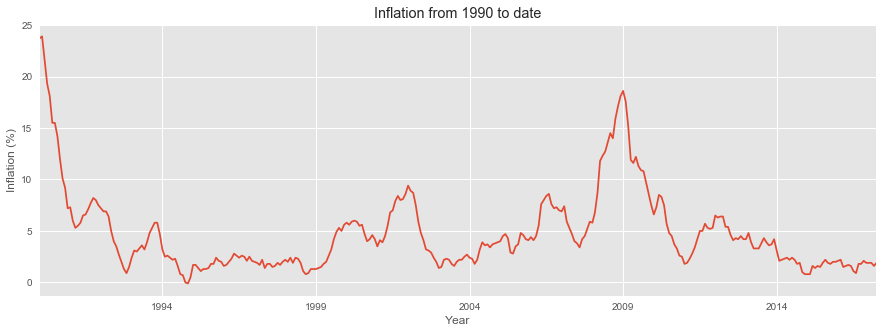

In [4]:
# Plotting the 12 month inflation rates from 1990 to date from the dataframe inflation

fig1, ax = plt.subplots(figsize = (15,5))

inflation.plot(ax=ax, legend = False)
ax.set_xlabel('Year')
ax.set_ylabel('Inflation (%)')
ax.set_title('Inflation from 1990 to date')

As explained by the graph above, the inflation fluctuates and shows a lot of variability. In 1990, we have the inflation coming down from having been very high in the late 80´s in part do to increased oil prices and the decision made by the US to abandon the gold standard. That being said, the factors influencing inflation and the reason for its behaviour are out of the scope of this project. The graph also shows a rise in the early 2000´s (housing boom in Iceland) and then again in 2008 subsequently after the most recent financial crisis.

This eradic behaviour and instability has led to the introduction of inflation indexation as a means to mitigate the effects of these constant fluctuations.

In [5]:
# Inflation summary statistics

inflationStatistics = inflation.describe([.25, .50, .75, .95])
inflationStatistics

,Value
count,328.000000
mean,4.754268
std,3.965638
min,-0.100000
25%,2.000000
50%,3.700000
75%,5.900000
95%,13.285000
max,23.900000


In [6]:
# Calculating the Upper and Lower Specification limits by using a deviation of 3 sigma

USL = inflationStatistics.T['mean'] + 3 * inflationStatistics.T['std']
LSL = inflationStatistics.T['mean'] - 3 * inflationStatistics.T['std']
print ('The Upper Specification limit is', USL,
       'and the Lower Specification Limit is', LSL)

The Upper Specification limit is Value    16.651181
dtype: float64 and the Lower Specification Limit is Value   -7.142644
dtype: float64


We can see there are inflation values outside the 3 standard deviation specification limits, but the max is 23.9 while the USL is 16.65. This supports the undesired variance in the inflation somewhat.

# Bank Interest Data

To be able to analyse the loan options we have to include the interest rates on the loans. The following data comes from the Central Bank of Iceland and includes the monthly interest rates on mortgage loans offered by the banks. We have the lowest and highest rates offered for both indexed and non-indexed loans and the accompanied inflation rate. The data spans back to January 2004.

In [7]:
# Bank Interest data read from the Central Bank of Iceland
bankInterests = pd.read_excel('http://www.cb.is/library/Skraarsafn---EN/Interest-rates/vxban.xls')
# Data cleaned up
bankInterests = bankInterests[9:len(bankInterests)-9]
bankInterests.columns = ['Year', 'Month', 'General savings accounts', 'Empty_1', 'Non-Indexed Lowest rate', 'Non-Indexed Highest rate', 'Empty_2', 'Indexed Lowest rate', 'Indexed Highest rate', 'Empty_3', 'Penalty rates in ISK', 'General interest on non-indexed loans', 'General interest on indexed loans', 'Interest on damage claims']
bankInterests['Year'] = bankInterests['Year'].replace('Í lok', '2003').replace('tímabils', '2003')
# Only desired columns chosen
bankInterests = bankInterests[['Year', 'Month', 'Non-Indexed Lowest rate', 'Non-Indexed Highest rate', 'Indexed Lowest rate', 'Indexed Highest rate']]
# Cells with the string 'NaN' replaced with the numpy NaN value
bankInterests = bankInterests.replace('NaN',np.NaN)
# Date parsed into desired format
bankInterests['Year and Month'] = bankInterests['Year'].map(str)
bankInterests = bankInterests[bankInterests['Month'].notnull()]
bankInterests = bankInterests.reset_index(drop=True)
bankInterests['Month'] = bankInterests['Month'].replace('Janúar', 'January').replace('Febrúar', 'February').replace('Mars', 'March').replace('Apríl', 'April').replace('Maí', 'May').replace('Júní', 'June').replace('Júlí', 'July').replace('Ágúst', 'August').replace('Október', 'October').replace('Nóvember', 'November').replace('Desember', 'December')

for i in range(0, len(bankInterests)):
    if pd.isnull(bankInterests.loc[i, 'Year']):
        bankInterests.loc[i, 'Year'] = bankInterests.loc[i-1, 'Year']

for i in range(0, len(bankInterests)):
    bankInterests.loc[i, 'Year and Month'] = dt.datetime.strptime(bankInterests.loc[i, 'Month'] + ' ' + str(bankInterests.loc[i, 'Year']),"%B %Y")
bankInterests = bankInterests.set_index(bankInterests['Year and Month'])
# Inflation added to DataFrame
bankInterests['Inflation'] = inflation['Value']

In [8]:
rate = bankInterests[['Indexed Lowest rate', 'Indexed Highest rate', 'Non-Indexed Lowest rate', 'Non-Indexed Highest rate', 'Inflation']]

rate.head()

,Indexed Lowest rate,Indexed Highest rate,Non-Indexed Lowest rate,Non-Indexed Highest rate,Inflation
Year and Month,,,,,
2004-01-01,5.60,11.15,7.95,13.5,2.4
2004-02-01,5.55,11.10,7.95,13.7,2.3
2004-03-01,5.50,11.10,7.95,13.7,1.8
2004-04-01,5.40,11.10,7.75,13.7,2.2
2004-05-01,5.40,11.10,7.75,13.7,3.2


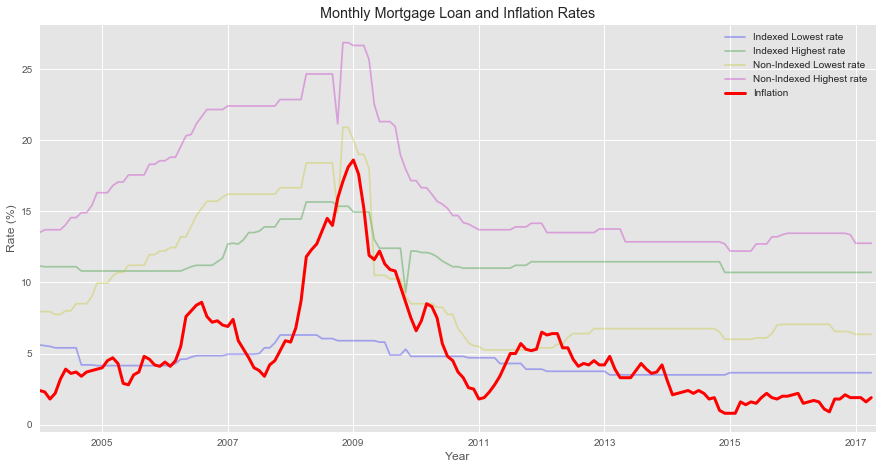

In [9]:
# Plotting the dataframe rate and comparing the rates to the inflation.

fig2, ax = plt.subplots(figsize = (15,7.5))
# Rates and inflation plotted into one diagram
rate['Indexed Lowest rate'].plot(ax=ax, color = 'b', alpha = 0.3)
rate['Indexed Highest rate'].plot(ax=ax, color = 'g', alpha = 0.3)
rate['Non-Indexed Lowest rate'].plot(ax=ax, color = 'y', alpha = 0.3)
rate['Non-Indexed Highest rate'].plot(ax=ax, color = 'm', alpha = 0.3)
rate['Inflation'].plot(ax=ax, color = 'r', lw = 3)
ax.legend()
ax.set_ylabel('Rate (%)')
ax.set_xlabel('Year')
ax.set_title('Monthly Mortgage Loan and Inflation Rates')

The figure above shows the relationshiop between the interest rates and the inflation. Initial inspection hints a correlation between the inflation and interest rates, but the rates seem to follow the inflation's dips and rises to quite an extent. Let's inspect this relationship and run the correlations.

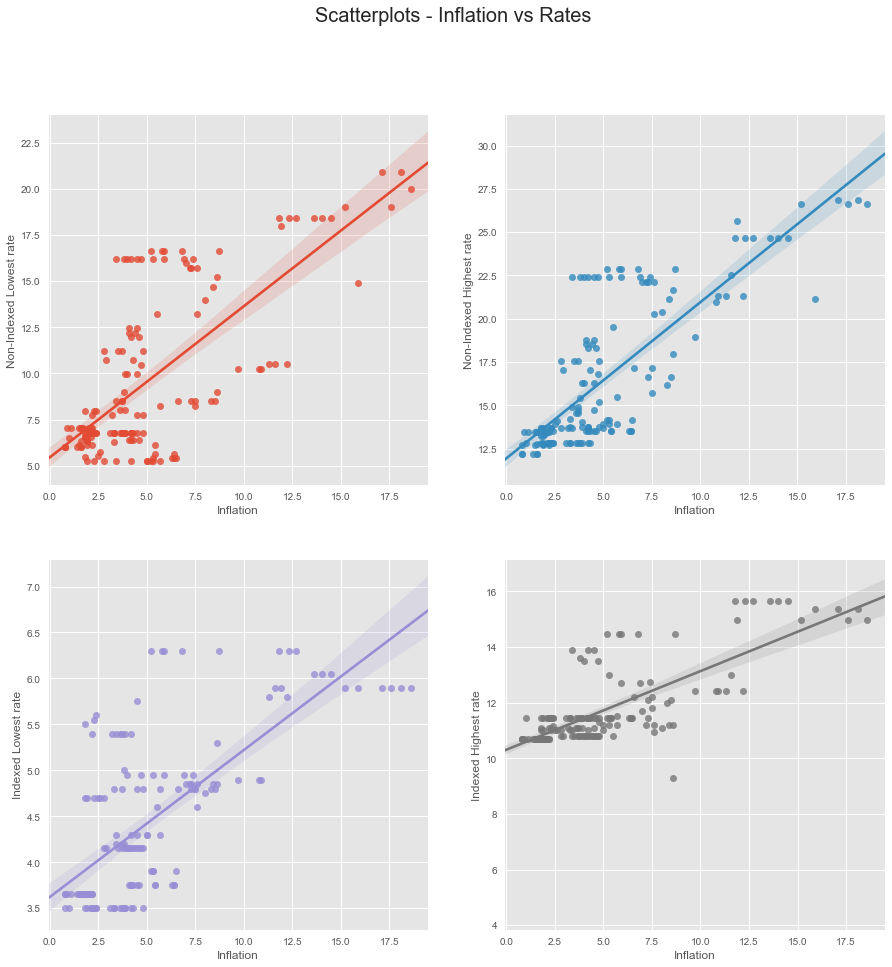

In [10]:
rate = bankInterests[['Indexed Lowest rate', 'Indexed Highest rate', 'Non-Indexed Lowest rate', 'Non-Indexed Highest rate', 'Inflation']].reset_index()
# Subplot of size 2x2 added
fig3, ax = plt.subplots(2, 2, figsize = (15, 15))
# Rows with NaN removed
rate = rate.dropna()
sns.regplot(x='Inflation',y='Non-Indexed Lowest rate',  ax = ax[0,0],data=rate, fit_reg=True) 
sns.regplot(x='Inflation',y='Non-Indexed Highest rate',  ax = ax[0,1],data=rate, fit_reg=True) 
sns.regplot(x='Inflation',y='Indexed Lowest rate',  ax = ax[1,0],data=rate, fit_reg=True) 
sns.regplot(x='Inflation',y='Indexed Highest rate',  ax = ax[1,1],data=rate, fit_reg=True) 
fig3.suptitle('Scatterplots - Inflation vs Rates', size = 20)

The scatter plots above show correlations between the inflation and the interest rates. The interest rates increase with the increased inflation. This is an expected behaviour.

To verify the correlations betweeen the Inflation and the interest rates indicated by the scatter plots, we find the Pearson coefficient (correlation coefficient) for each pair. Below is a heatmap that shows the correlation between different forms of loan interest rates and the inflation.

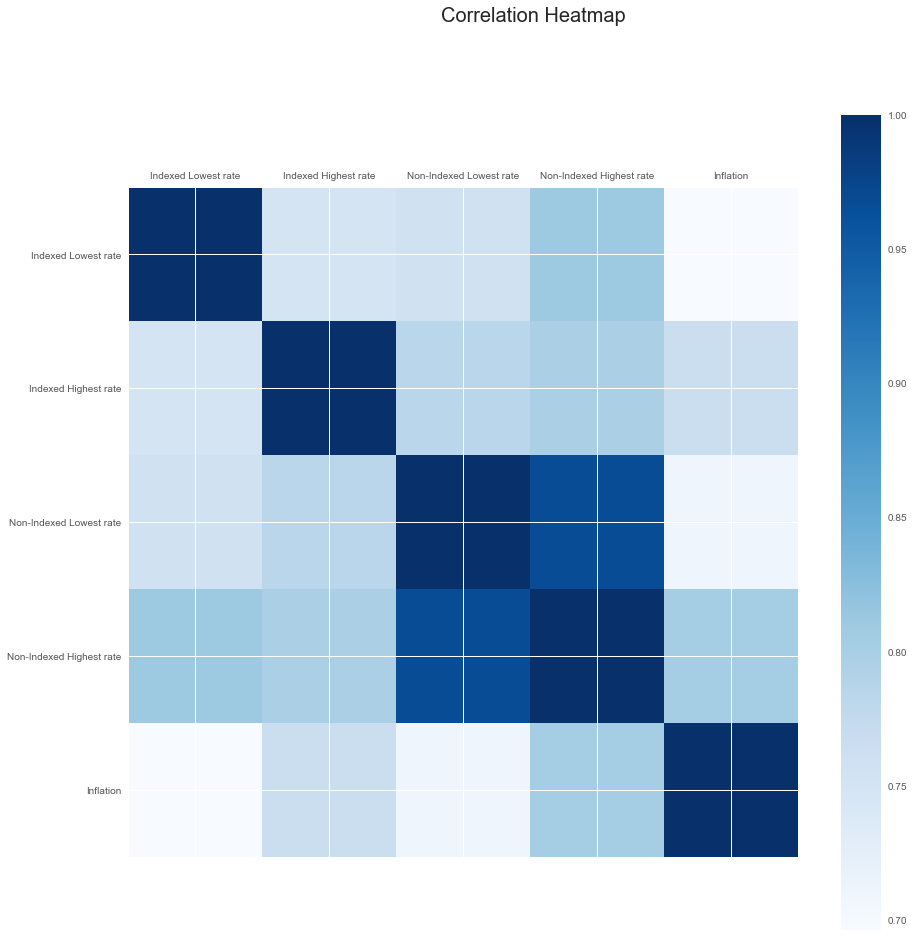

In [11]:
fig4= plt.figure(figsize=(15,15))
ax = fig4.add_subplot(111)
# Column titles added to heatmap
ax.set_xticklabels(rate.columns)
ax.set_yticklabels(rate.columns)
cax = ax.matshow(rate.corr(), interpolation='nearest', cmap='Blues')
# Color bar added on the right
fig4.colorbar(cax)
fig4.suptitle('Correlation Heatmap', size = 20)

In [12]:
# Correlation of rates set to a new DataFrame
rateCorrelation = rate.corr()[['Inflation']]
# Correlation of inflation to inflation removed
rateCorrelation = rateCorrelation[rateCorrelation['Inflation'] != 1.0]
# Sorted in a descending order
rateCorrelation = rateCorrelation.sort_values('Inflation', 
                                              ascending=False)
# Correlation of rates to inflation displayed
rateCorrelation

,Inflation
Non-Indexed Highest rate,0.803801
Indexed Highest rate,0.764118
Non-Indexed Lowest rate,0.710320
Indexed Lowest rate,0.696311


The table above shows the Pearson coefficient for each pair of inflation and interest rate. According to these results there is a high correlation, the lowest (0.70) being between inflation and the indexed lowest rate and the highest (0.80) between inflation and non-indexed highest rate. This tells us that the banks adjust the interests they're offering, to compensate for the change in inflation. The conclusion here is that the interests on the non-indexed mortgage loans also follow the inflation, making the two loan options not so different in praxis. It's evident that both loan are adjusted to inflation one way or another.

Another very interesting thing to look at is the order of the correlations, highest to lowest. Before we analyse that, lets look at how the interest rates are structured and how the interest payments are calculated.

**Indexed:**

Yields on indexed accounts consist of interest and indexation. The indexation is calculated on the lowest balance for each month and changes according to the inflation. The indexation is then added to the balance like so:
    
    Start Balance(i+1) = End Balance(i) * Interest Rate(i)
    
    where i is the payment period.

So for indexed loans, the interest payments are calculated by using the interest rate on the CPI adjusted balance like so

    Interest Payment(i) = Start Balance(i) * Interest Rate(i)
    
**Non-Indexed rates:**

In the case of non-indexed loans we don't have indexation, but the inflation still plays a roll. To see how, lets break down the interest rate.

    Interest Rate(i) = Bank Interest rate(i) + Projected Inflation Rate(i) + Risk Premium Rate{i)
    
     where i is the payment period.

There is always uncertainty in projecting or forecasting inflation, especially in Iceland.  The Risk Premium rate is the added rate lenders use to mitigate the risk of using the projected inflation.

# Loan Payment Plan Calculator

#### loanCalculator(amount, length, inflation, interest, issueYear, issueMonth, issueDay, loantype, indexation)

The function loanCalculator is a dynamic function that returns a loan payment plan (as a dataframe) given 9 loan parameters.

### Parameters:

##### amount:
    A loan amount as int or float

##### length:
    Length of payment plan in years as int or float

##### inflation:
    A series of 12 month inflation rates or a fixed rate as int or float

##### interest:
    A series of 12 month interest rates or a fixed rate as int or float

##### issueYear:
    The year the loan is issued as int

##### issueMonth:
    The month of year the loan is issued as int

##### issueDay:
    The day of month the loan is issued as int

##### loantype:
    The payment plan as a string. Takes 'equal principal payments' or 'equal payments'

##### indexation:
    Indicates whether loan is indexed or not as a string. Takes 'no' for non-indexed and 'yes' for indexed

In [13]:
def loanCalculator(amount, length, inflation, interest, issueYear, issueMonth, issueDay, loantype, indexation):
    
    periods = length * 12
    issueDate = dt.date(issueYear, issueMonth, issueDay)
    
    columns = ['Start Balance', 'Total Payment', 'Principal Payment', 'Interest Payment', 'End Balance']
    index = pd.date_range(start = issueDate, periods = periods, freq = 'M')
    payments = pd.DataFrame(index = index, columns = columns)
    
    # Dealing with interest and inflation rates, whether the input is a series or an int/float
    
    if type(interest) == pd.Series:
        monthlyInterestRate = (interest/12)/100
    else:
        monthlyInterestRate=[]
        for i in range(len(payments)):
            monthlyInterestRate.append((interest/12)/100)
            
        monthlyInterestRate=pd.Series(monthlyInterestRate)
        
    if type(inflation) == pd.Series:
        monthlyInflationRate = (inflation/12)/100
    else:
        monthlyInflationRate=[]
        for i in range(len(payments)):
            monthlyInflationRate.append((inflation/12)/100)
            
        monthlyInflationRate=pd.Series(monthlyInflationRate)
   
    # This for loop calculates the payment plan for the 4 loan options. 

    for i in range(len(payments)-1):
        
        if loantype == 'equal principal payments' and indexation == 'no': # Non-Indexed Equal Principal Payments
        
            # first line of payment plan
        
            payments.iloc[0,0] = amount          
            payments.iloc[0,2] = amount/periods
            payments.iloc[0,3] = payments.iloc[0,0] * monthlyInterestRate[0]
            payments.iloc[0,1] = payments.iloc[0,2] + payments.iloc[0,3]
            payments.iloc[0,4] = payments.iloc[0,0] - payments.iloc[0,2]
                
            i=i+1
                
            payments.iloc[i,0] = payments.iloc[(i-1),4]
            payments.iloc[i,2] = amount/periods
            payments.iloc[i,3] = payments.iloc[i,0] * monthlyInterestRate[i]
            payments.iloc[i,1] = payments.iloc[i,2] + payments.iloc[i,3]
            payments.iloc[i,4] = payments.iloc[i,0] - payments.iloc[i,2]
            

        elif loantype == 'equal payments' and indexation == 'no': # Non-Indexed Equal Payments
         
            # first line of payment plan
        
            payments.iloc[0,0] = amount
            payments.iloc[0,1] = (monthlyInterestRate[0]*amount)/(1-(1+monthlyInterestRate[0])**-periods)
            payments.iloc[0,3] = payments.iloc[0,0] * monthlyInterestRate[0]
            payments.iloc[0,2] = payments.iloc[0,1] - payments.iloc[0,3]
            payments.iloc[0,4] = payments.iloc[0,0] - payments.iloc[0,2]
    
            i=i+1
    
            payments.iloc[i,0] = payments.iloc[(i-1),4]
            payments.iloc[i,1] = (monthlyInterestRate[i]*amount)/(1-(1+monthlyInterestRate[i])**-periods)
            payments.iloc[i,3] = payments.iloc[i,0] * monthlyInterestRate[i]
            payments.iloc[i,2] = payments.iloc[i,1] - payments.iloc[i,3]
            payments.iloc[i,4] = payments.iloc[i,0] - payments.iloc[i,2]
            

        elif loantype == 'equal principal payments' and indexation == 'yes': # Indexed Equal Principal Payments
        
            # first line of payment plan
        
            payments.iloc[0,0] = amount * (1+monthlyInflationRate[0])
            payments.iloc[0,2] = payments.iloc[0,0] / periods
            payments.iloc[0,3] = payments.iloc[0,0] * monthlyInterestRate[0]
            payments.iloc[0,4] = payments.iloc[0,0] - payments.iloc[0,2]
            payments.iloc[0,1] = payments.iloc[0,2] + payments.iloc[0,3]
    
            i=i+1
    
            payments.iloc[i,0] = payments.iloc[(i-1),4] * (1 + monthlyInflationRate[i])
            payments.iloc[i,2] = payments.iloc[(i-1),2] * (1 + monthlyInflationRate[i])
            payments.iloc[i,3] = payments.iloc[i,0] * monthlyInterestRate[i]
            payments.iloc[i,4] = payments.iloc[i,0] - payments.iloc[i,2]
            payments.iloc[i,1] = payments.iloc[i,2] + payments.iloc[i,3] 


        elif loantype == 'equal payments' and indexation == 'yes': # Indexed Equal Payments
            
            # first line of payment plan
            
            payments.iloc[0,0] = amount * (1+monthlyInflationRate[0])
            payments.iloc[0,1] = (payments.iloc[0,0] * monthlyInterestRate[0]) / (1-(1+monthlyInterestRate[0])**-periods)
            payments.iloc[0,3] = payments.iloc[0,0] * monthlyInterestRate[0]
            payments.iloc[0,2] = payments.iloc[0,1] - payments.iloc[0,3]
            payments.iloc[0,4] = payments.iloc[0,0] - payments.iloc[0,2]
    
            i=i+1
    
            payments.iloc[i,0] = payments.iloc[(i-1),4] * (1 + monthlyInflationRate[i])
            payments.iloc[i,1] = payments.iloc[(i-1),1] * (1 + monthlyInflationRate[i])
            payments.iloc[i,3] = payments.iloc[i,0] * monthlyInterestRate[i]
            payments.iloc[i,2] = payments.iloc[i,1] - payments.iloc[i,3]
            payments.iloc[i,4] = payments.iloc[i,0] - payments.iloc[i,2]
            
            
    return payments;

# Payment Plans
### Projected <br>

We will be looking at 4 different payment plans for the 4 different types of loans. For all plans we have a 25 year, 10.000.000 isk loan, issued on May 8th 2017. These payment plans are as projected by lenders when loans are issued, given they offer the same interests and inflation as used in the following example.

#### Payment Plan 1

Indexed: no<br>
Payments: equal principal payments<br>
Fixed Interest (%): 6.5<br>
Fixed Inflation (%): 0.0 (irrelevant)

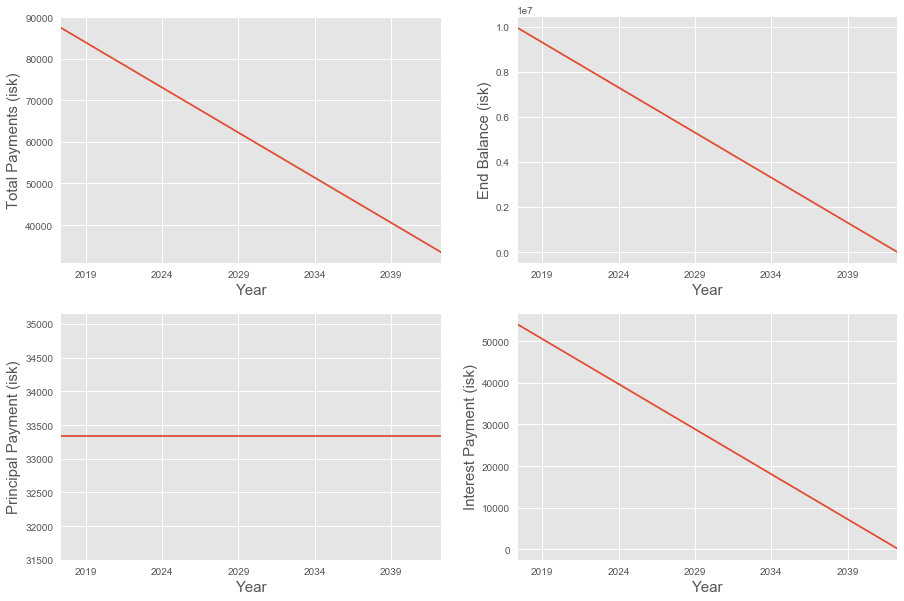

In [14]:
# Plotting up Total Monthly Payments, End Balance, Principal Payments and Interest Payments for the example loan
# Using the loanCalculator function we find the loan payment plan. The paramaters can be changed if desired
# The following 3 plans follow the same procedure 

payments = loanCalculator(10000000, 25, 0, 6.5, 2017, 5, 8, 'equal principal payments', 'no')

fig4, ax = plt.subplots(2, 2, figsize = (15, 10))

payments['Total Payment'].plot(ax=ax[0,0])
ax[0,0].set_ylabel('Total Payments (isk)', size = 15)
ax[0,0].set_xlabel('Year', size = 15)
  
payments['End Balance'].plot(ax=ax[0,1])
ax[0,1].set_ylabel('End Balance (isk)', size = 15)
ax[0,1].set_xlabel('Year', size = 15)
   
payments['Principal Payment'].plot(ax=ax[1,0])
ax[1,0].set_ylabel('Principal Payment (isk)', size = 15)
ax[1,0].set_xlabel('Year', size = 15)
   
payments['Interest Payment'].plot(ax=ax[1,1])
ax[1,1].set_ylabel('Interest Payment (isk)', size = 15)
ax[1,1].set_xlabel('Year', size = 15)

#### Payment Plan 2

Indexed: no<br>
Payments: equal payments<br>
Fixed Interest (%): 6.5<br>
Fixed Inflation (%): 0.0 (irrelevant)

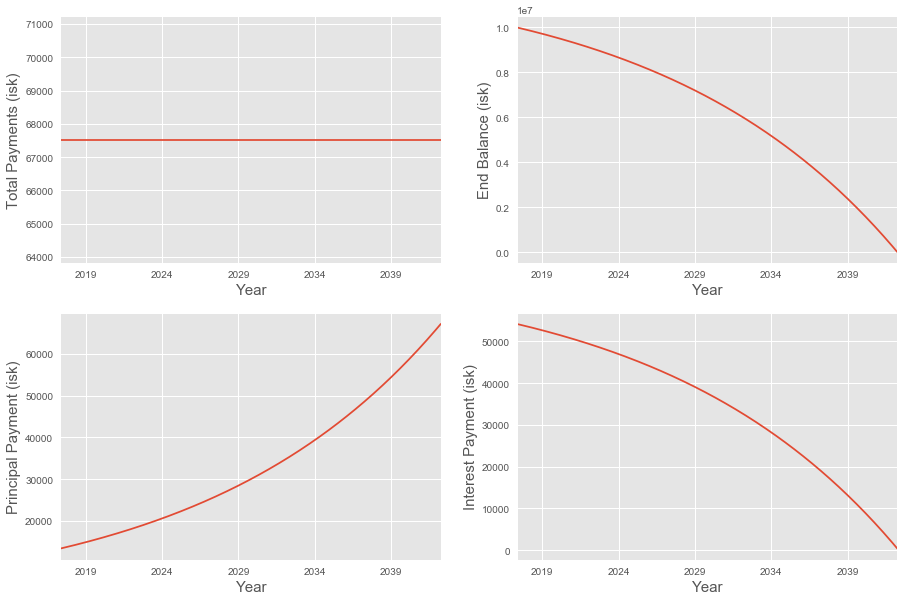

In [15]:
payments = loanCalculator(10000000, 25, 0, 6.5, 2017, 5, 8, 'equal payments', 'no')

fig6, ax = plt.subplots(2, 2, figsize = (15, 10))

payments['Total Payment'].plot(ax=ax[0,0])
ax[0,0].set_ylabel('Total Payments (isk)', size = 15)
ax[0,0].set_xlabel('Year', size = 15)
  
payments['End Balance'].plot(ax=ax[0,1])
ax[0,1].set_ylabel('End Balance (isk)', size = 15)
ax[0,1].set_xlabel('Year', size = 15)
   
payments['Principal Payment'].plot(ax=ax[1,0])
ax[1,0].set_ylabel('Principal Payment (isk)', size = 15)
ax[1,0].set_xlabel('Year', size = 15)
   
payments['Interest Payment'].plot(ax=ax[1,1])
ax[1,1].set_ylabel('Interest Payment (isk)', size = 15)
ax[1,1].set_xlabel('Year', size = 15)

#### Payment Plan 3

Indexed: yes<br>
Payments: equal principal payments<br>
Fixed Interest (%): 3.5<br>
Fixed Inflation (%): 1.5

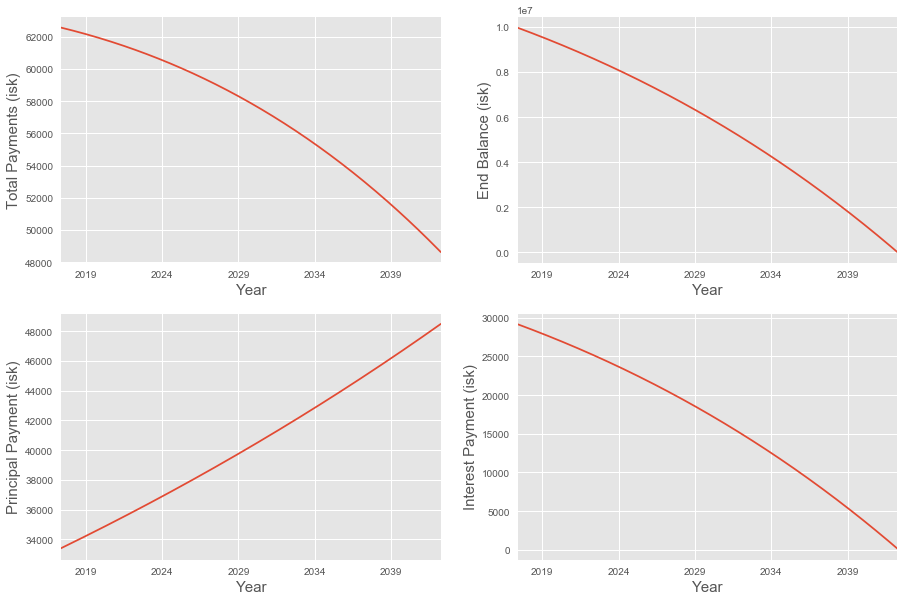

In [16]:
payments = loanCalculator(10000000, 25, 1.5, 3.5, 2017, 5, 8, 'equal principal payments', 'yes')

fig7, ax = plt.subplots(2, 2, figsize = (15, 10))

payments['Total Payment'].plot(ax=ax[0,0])
ax[0,0].set_ylabel('Total Payments (isk)', size = 15)
ax[0,0].set_xlabel('Year', size = 15)
  
payments['End Balance'].plot(ax=ax[0,1])
ax[0,1].set_ylabel('End Balance (isk)', size = 15)
ax[0,1].set_xlabel('Year', size = 15)
   
payments['Principal Payment'].plot(ax=ax[1,0])
ax[1,0].set_ylabel('Principal Payment (isk)', size = 15)
ax[1,0].set_xlabel('Year', size = 15)
   
payments['Interest Payment'].plot(ax=ax[1,1])
ax[1,1].set_ylabel('Interest Payment (isk)', size = 15)
ax[1,1].set_xlabel('Year', size = 15)

#### Payment Plan 4

Indexed: yes<br>
Payments: equal payments<br>
Fixed Interest (%): 3.5<br>
Fixed Inflation (%): 1.5

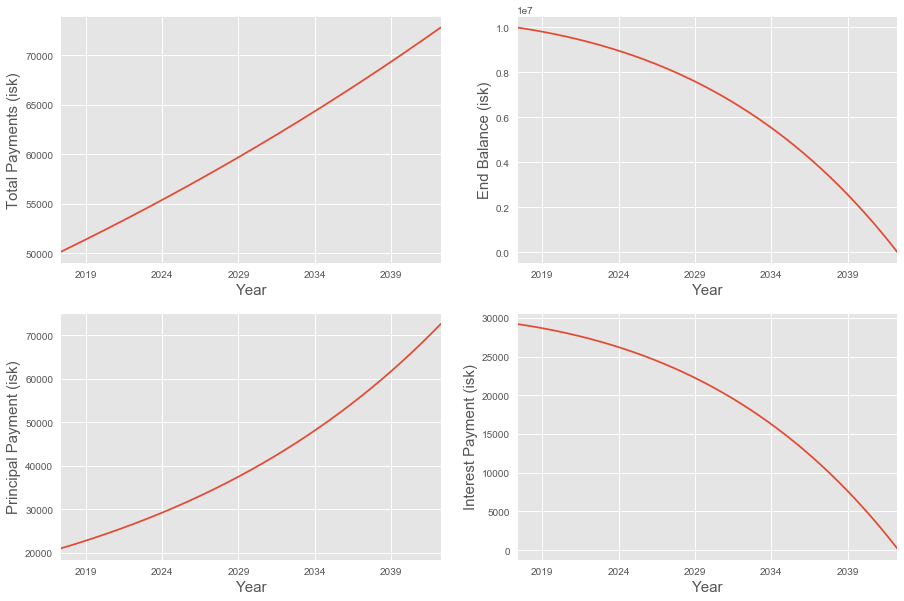

In [17]:
payments = loanCalculator(10000000, 25, 1.5, 3.5, 2017, 5, 8, 'equal payments', 'yes')

fig8, ax = plt.subplots(2, 2, figsize = (15, 10))

payments['Total Payment'].plot(ax=ax[0,0])
ax[0,0].set_ylabel('Total Payments (isk)', size = 15)
ax[0,0].set_xlabel('Year', size = 15)
  
payments['End Balance'].plot(ax=ax[0,1])
ax[0,1].set_ylabel('End Balance (isk)', size = 15)
ax[0,1].set_xlabel('Year', size = 15)
   
payments['Principal Payment'].plot(ax=ax[1,0])
ax[1,0].set_ylabel('Principal Payment (isk)', size = 15)
ax[1,0].set_xlabel('Year', size = 15)
   
payments['Interest Payment'].plot(ax=ax[1,1])
ax[1,1].set_ylabel('Interest Payment (isk)', size = 15)
ax[1,1].set_xlabel('Year', size = 15)

Now we have seen what these projected payments look like but the actual payments never follow projections, as is normal. The payment plans change as inflation and interest change, both for indexed and non-indexed loans. Depending on the terms of the loans and type of loan, the lenders can adjust the interests and inflation on the loan to reflect the economic conditions at any given time. 

### Projected vs Actual<br>

The next step is to analyse the projected payment plan vs the actual plan. To do that we use real historical figures for inflation and bank interests addressed earlier in this report.

In [18]:
# Finding the average interest rates

rate['Indexed AVG'] = rate[['Indexed Lowest rate','Indexed Highest rate']].mean(axis=1)
rate['Non-Indexed AVG'] = rate[['Non-Indexed Lowest rate','Non-Indexed Highest rate']].mean(axis=1)

rate.head()

,Year and Month,Indexed Lowest rate,Indexed Highest rate,Non-Indexed Lowest rate,Non-Indexed Highest rate,Inflation,Indexed AVG,Non-Indexed AVG
0,2004-01-01,5.60,11.15,7.95,13.5,2.4,8.375,10.725
1,2004-02-01,5.55,11.10,7.95,13.7,2.3,8.325,10.825
2,2004-03-01,5.50,11.10,7.95,13.7,1.8,8.300,10.825
3,2004-04-01,5.40,11.10,7.75,13.7,2.2,8.250,10.725
4,2004-05-01,5.40,11.10,7.75,13.7,3.2,8.250,10.725


#### Indexed

In [19]:
# In this example, we can only manipulate the following 4 parameters for simplification. The other 5 are fixed.

year = 2004 # The earliest data is January 1st 2004
month = 1
day = 1
amount = 10000000

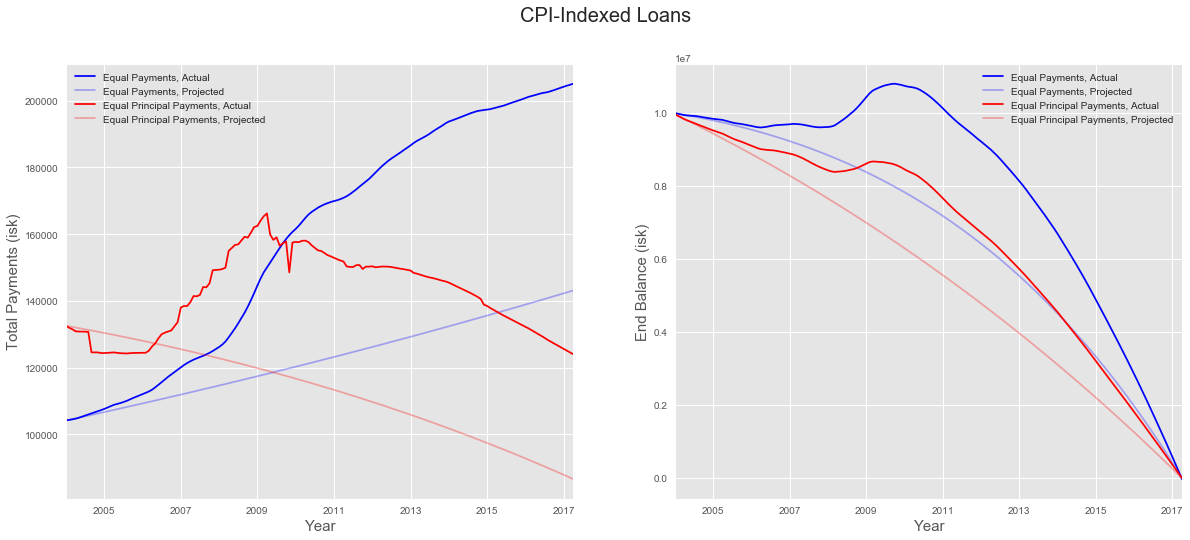

In [20]:
# Setting the parameters and executing the required manipulation

rate = rate.set_index(rate['Year and Month'])

ratePeriod = rate[str(year) + '-' + str(month):]

inflation = ratePeriod['Inflation']
interest = ratePeriod['Indexed AVG']
projectedInterest = interest[0]
projectedInflation = inflation[0]

length = len(ratePeriod)/12

# Setting up the payment plan (Actual and Projected) and plotting

indPaymentsEqualPayActual = loanCalculator(amount, length, inflation, interest, year, month, day, 'equal payments', 'yes')
indPaymentsEqualPayProjected = loanCalculator(amount, length, projectedInflation, projectedInterest, year, month, day, 'equal payments', 'yes')
indPaymentsEqualPriActual = loanCalculator(amount, length, inflation, interest, year, month, day, 'equal principal payments', 'yes')
indPaymentsEqualPriProjected = loanCalculator(amount, length, projectedInflation, projectedInterest, year, month, day, 'equal principal payments', 'yes')

fig8, ax = plt.subplots(1, 2, figsize = (20, 8))

indPaymentsEqualPayActual['Total Payment'].plot(ax=ax[0], color = 'b')
indPaymentsEqualPayProjected['Total Payment'].plot(ax=ax[0], color = 'b', alpha = 0.3) 
indPaymentsEqualPriActual['Total Payment'].plot(ax=ax[0], color = 'r')
indPaymentsEqualPriProjected['Total Payment'].plot(ax=ax[0], color = 'r', alpha = 0.3)
ax[0].set_ylabel('Total Payments (isk)', size = 15)
ax[0].set_xlabel('Year', size = 15)
ax[0].legend(['Equal Payments, Actual','Equal Payments, Projected','Equal Principal Payments, Actual','Equal Principal Payments, Projected'])

indPaymentsEqualPayActual['End Balance'].plot(ax=ax[1], color = 'b')
indPaymentsEqualPayProjected['End Balance'].plot(ax=ax[1], color = 'b', alpha = 0.3)
indPaymentsEqualPriActual['End Balance'].plot(ax=ax[1], color = 'r')
indPaymentsEqualPriProjected['End Balance'].plot(ax=ax[1], color = 'r', alpha = 0.3)
ax[1].set_ylabel('End Balance (isk)', size = 15)
ax[1].set_xlabel('Year', size = 15)
ax[1].legend(['Equal Payments, Actual','Equal Payments, Projected','Equal Principal Payments, Actual','Equal Principal Payments, Projected'])

fig8.suptitle('CPI-Indexed Loans', size = 20)

#### Non-Indexed

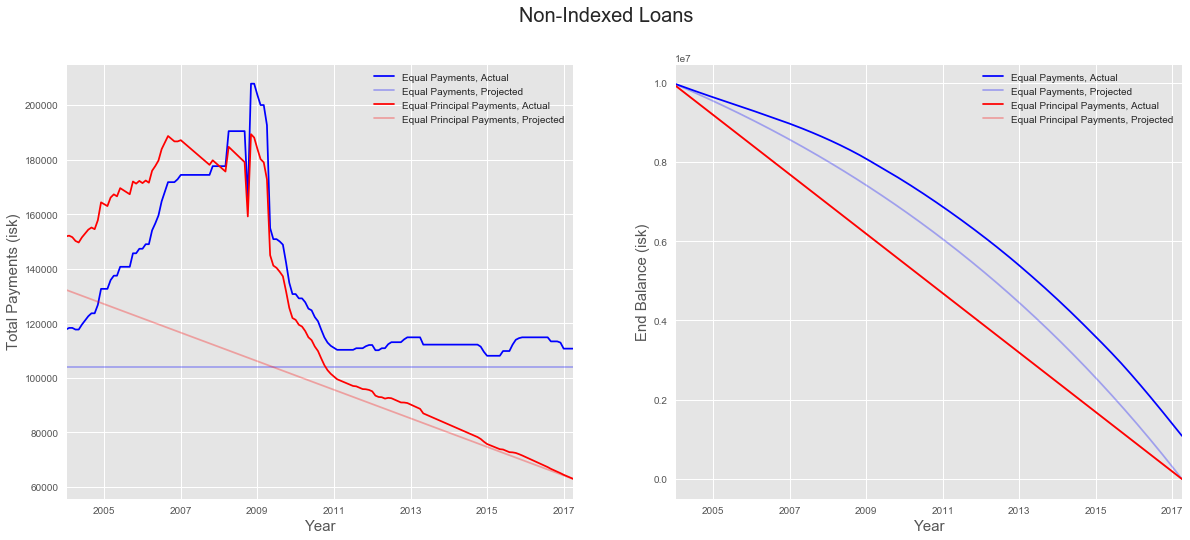

In [21]:
# Setting the parameters and executing the required manipulation

interest = ratePeriod['Non-Indexed AVG']

# Setting up the payment plan (Actual and Projected) and plotting

paymentsEqualPayActual = loanCalculator(amount, length, inflation, interest, year, month, day, 'equal payments', 'no')
paymentsEqualPayProjected = loanCalculator(amount, length, projectedInflation, projectedInterest, year, month, day, 'equal payments', 'no')
paymentsEqualPriActual = loanCalculator(amount, length, inflation, interest, year, month, day, 'equal principal payments', 'no')
paymentsEqualPriProjected = loanCalculator(amount, length, projectedInflation, projectedInterest, year, month, day, 'equal principal payments', 'no')

fig9, ax = plt.subplots(1, 2, figsize = (20, 8))

paymentsEqualPayActual['Total Payment'].plot(ax=ax[0], color = 'b')
paymentsEqualPayProjected['Total Payment'].plot(ax=ax[0], color = 'b', alpha = 0.3) 
paymentsEqualPriActual['Total Payment'].plot(ax=ax[0], color = 'r')
paymentsEqualPriProjected['Total Payment'].plot(ax=ax[0], color = 'r', alpha = 0.3)
ax[0].set_ylabel('Total Payments (isk)', size = 15)
ax[0].set_xlabel('Year', size = 15)
ax[0].legend(['Equal Payments, Actual','Equal Payments, Projected','Equal Principal Payments, Actual','Equal Principal Payments, Projected'])

paymentsEqualPayActual['End Balance'].plot(ax=ax[1], color = 'b')
paymentsEqualPayProjected['End Balance'].plot(ax=ax[1], color = 'b', alpha = 0.3)
paymentsEqualPriActual['End Balance'].plot(ax=ax[1], color = 'r')
paymentsEqualPriProjected['End Balance'].plot(ax=ax[1], color = 'r', alpha = 0.3)
ax[1].set_ylabel('End Balance (isk)', size = 15)
ax[1].set_xlabel('Year', size = 15)
ax[1].legend(['Equal Payments, Actual','Equal Payments, Projected','Equal Principal Payments, Actual','Equal Principal Payments, Projected'])

fig9.suptitle('Non-Indexed Loans', size = 20)

When comparing the actual payments to the projected payment plan, we can see there is a big difference.

For the indexed loans the actual payments deviate from the projection very early on in the payment process and end up being much higher then anticipated. In turn the balance/principal behaves similarly. It starts off decreasing very slowly until it hits a significant hike before starting to drop again and level off with the projections.

Looking at the non-indexed loans we also see a massive difference. What should be a very steady payment process turns out to be a very fluctuating one, with payments rising fast and doubling in and after the mid 2000's before they finally even out. We also see the balance/principal decreasing at a slower rate in the beginning.

This variability needs to be addressed to try to make sense of it all.

# Variance

The actual payments we have seen vary greatly in terms of total payment, something a lendee wants to try to avoid. Not knowing how the payments will develop is very unfortunate, especially since salaries are not CPI indexed and could easily fall behind, leaving the lendee in massive unforseen debt. The following will shed a light on the variability involved.

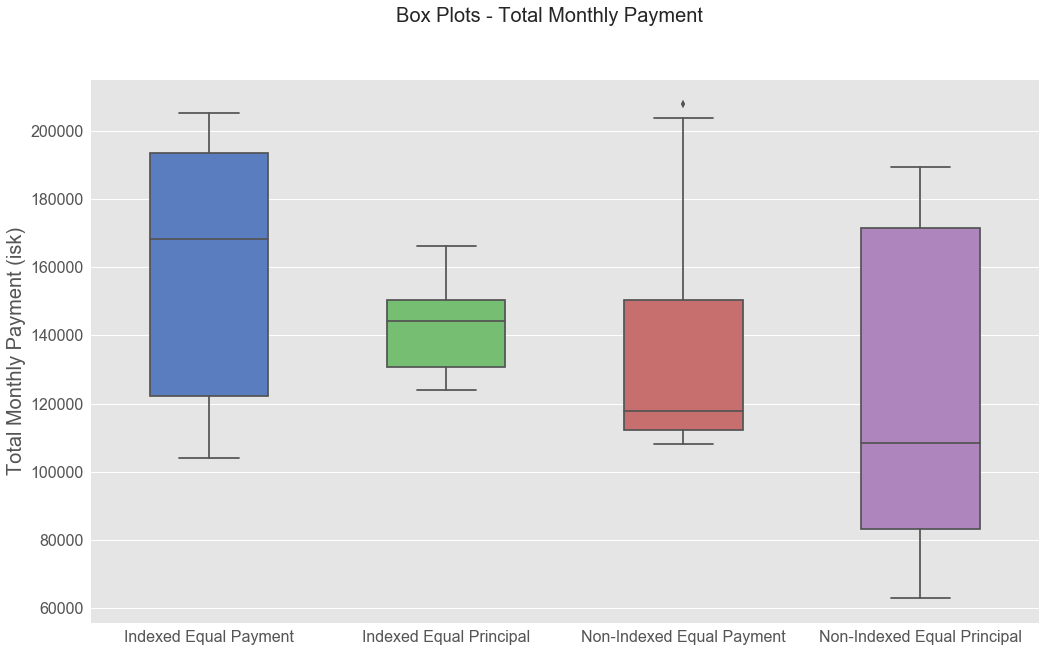

In [22]:
# Creating a dataframe including the total payments for the 4 types of loans and drawing box plots

equalMonthlyTotalPayments = {'Indexed Equal Payment': indPaymentsEqualPayActual['Total Payment'],
            'Non-Indexed Equal Payment': paymentsEqualPayActual['Total Payment'],
                     'Indexed Equal Principal': indPaymentsEqualPriActual['Total Payment'],
                      'Non-Indexed Equal Principal': paymentsEqualPriActual['Total Payment']}

fig10, ax = plt.subplots(figsize = (17,10))

equalMonthlyTotalPayments = pd.DataFrame(data = equalMonthlyTotalPayments)

sns.boxplot(data=equalMonthlyTotalPayments, ax=ax, palette = 'muted', width = 0.5)
ax.tick_params(labelsize = 16)
ax.set_ylabel('Total Monthly Payment (isk)', size = 20)
fig10.suptitle('Box Plots - Total Monthly Payment', size = 20)

Out of the 4 loan options, the one that expresses the least amount of variability is the indexed equal principal payment loan. The other 3 show a great deal of variability which is particularily troubling when looking at the equal payment loan options, where you expect to have a small spread in monthly payment size.  These box plots show very efficiently the problem at hand and the risks that lenders and lendees face.

In [23]:
equalMonthlyTotalPayments = equalMonthlyTotalPayments.apply(pd.to_numeric)

In [24]:
# Summary statistics for the monthly payments of the 4 plans

summaryStats = equalMonthlyTotalPayments.describe()
summaryStats

,Indexed Equal Payment,Indexed Equal Principal,Non-Indexed Equal Payment,Non-Indexed Equal Principal
count,160.000000,160.000000,160.000000,160.000000
mean,158691.374730,142022.307202,133596.390855,123425.219727
std,35275.195779,12020.139854,28280.851948,44215.014943
min,104163.785362,124024.675221,108112.243200,62997.395833
25%,122276.517443,130818.274181,112204.364215,83299.479167
50%,168189.225027,144078.931665,117727.870200,108521.484375
75%,193335.883228,150299.842363,150231.187156,171442.057292
max,205063.387228,166207.371268,207846.494046,189335.937500


From the table above, we focus on 4 measures, mean, standard deviation, min and max.

First, lets compare the 2 equal payment loans. The max and min payment for both options are similar but looking at the average (mean) payments and their standard deviation we can see that the non-indexed one is a better option with a slightly lower average payment and less variability, explained by a lower standard deviation. The max payments are very similar

Second, lets compare the 2 equal principal payment loan options. The indexed option has a lower max payment, a much lower standard deviation but a slightly higher average monthly payment. Deciding between the two here, is not as straight forward. It depends on favoring lower average payments to lower variability or vice versa.

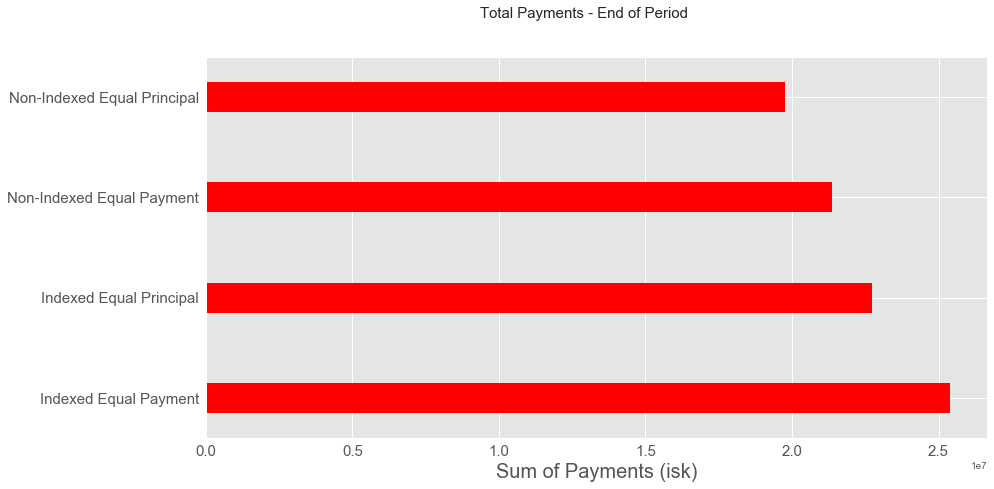

In [25]:
# Calculating the sum of payments throughout the loan period and plotting a bar chart.

totalPayments = equalMonthlyTotalPayments.sum()
fig11, ax = plt.subplots(figsize = (14, 7))

totalPayments.plot(kind='barh', ax=ax, width = 0.3, color = 'r')
ax.tick_params(labelsize = 15)
ax.set_xlabel('Sum of Payments (isk)', size = 20)
fig11.suptitle('Total Payments - End of Period', size = 15)

The indexed equal payment loan has the highest sum of payments, followed by the indexed equal principal payment loan. This bar chart along with the summary statistics seem to result in the favoring of the two non-indexed loan options, equal payments and equal principal payments.

# Cumulative Payments

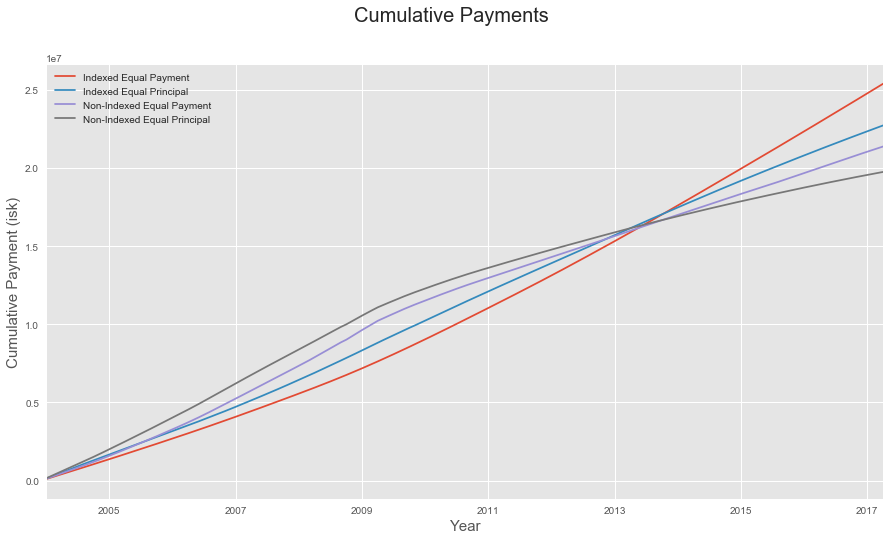

In [26]:
# Calculating the cumulative sum of payments over the loan period.

cumPayments = equalMonthlyTotalPayments.cumsum()

fig12, ax = plt.subplots(figsize = (15, 8))

cumPayments.plot(ax=ax)
ax.set_ylabel('Cumulative Payment (isk)', size = 15)
ax.set_xlabel('Year', size = 15)
fig12.suptitle('Cumulative Payments', size = 20)

The two non-indexed options have the lowest cumulative payment at the end of the loan period.

# Conclusion

In the introduction of this project we asked questions that we wanted answers to. Which loanform is the most economical? Which has the lowest monthly payments? Which has the least variability in monthly payments?

The data we have displayed answers these questions for us. We have seen that <b>Non-Indexed Equal Principal</b> loans are the most economical, they also have the lowest mean monthly payments, but they can vary significantly between months. <b>Indexed Equal Principal</b> loans however, have the lowest variability in monthly payments.

When we set out for this project we wanted to find <b>the best</b> loan form which most people should take. We have seen that there is no one ideal loan form, as it all comes down to what the individual is able to do and how he/she prioritizes the different loan attributes. If he/she can handle high variability in monthly payments it might make most sense to get a non-indexed equal principal loan, for example.

Analysis like this one is crucial for people who want to know how their loan might develop. We have seen that the projected payment plans do not tell the whole story as they depend on both fixed rates and fixed inflation, which is never the case in the Icelandic mortgage market.

Nevertheless, it should be noted that this analysis only shows a picture of how loans have developed in the past 13 years, and the 2008 financial crash has a large affect on the results. If it hadn't been for the financial crash, we might have found that other loan forms would be more economical.

To take this analysis even further, there are a few interesting things worth looking at.

* Acquire data on bank interests, dating back further than 2004 or to the introduction of the indexation
* Develop sophisticated inflation and interest forecasting models to analyse future payments
* Focus on prescriptive statistics in an effort to optimize loan payments
* Introduce the wage index, see how it interacts with the CPI and affects loan payments